# CPA on Firmware Implementation of Kuznyechik (GOST)

## GOST Trace Capture

In [1]:
SCOPETYPE = 'OPENADC' # options: OPENADC, CWNANO  
PLATFORM = 'CWLITEXMEGA' # options: CWLITEXMEGA/CW308_XMEGA, CWLITEARM/CW308_STM32F3, CWNANO 
CRYPTO_TARGET='KUZNYECHIK'
SS_VER='SS_VER_1_1'

In [2]:
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
scope.adc.samples = 24400 #options: 96000 for CW-PRO (CW1200), 24400 for CW-Lite, 131070 for CW-Husky

In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../firmware/mcu/simpleserial-gost
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWLITEXMEGA with CRYPTO_TARGET=KUZNYECHIK
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Size after:
   text	   data	    bss	    dec	    hex	filename
   4298	    322	    322	   4942	   134e	simpleserial-gost-CWLITEXMEGA.elf
+--------------------------------------------------------
+ Built for platform CW-Lite XMEGA with:
+ CRYPTO_TARGET = KUZNYECHIK
+ CRYPTO_OPTIONS = AES128C
+--------------------------------------------------------


In [5]:
cw.program_target(scope, prog, "../../firmware/mcu/simpleserial-gost/simpleserial-gost-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 4619 bytes


In [6]:
from tqdm.notebook import trange
import numpy as np
import time
from os import urandom

trace_array = []
textin_array = []

text = urandom(16)

N = 350
if PLATFORM=="CWNANO": #increase nano reliability
    N = 700
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    text = urandom(16)
    
trace_array = np.array(trace_array)

Capturing traces:   0%|          | 0/350 [00:00<?, ?it/s]

In [7]:
scope.dis()
target.dis()

In [8]:
assert len(trace_array) == N
print("✔️ OK to continue!")

✔️ OK to continue!


Again, let's quickly plot a trace to make sure everything looks as expected:

<IPython.core.display.Javascript object>


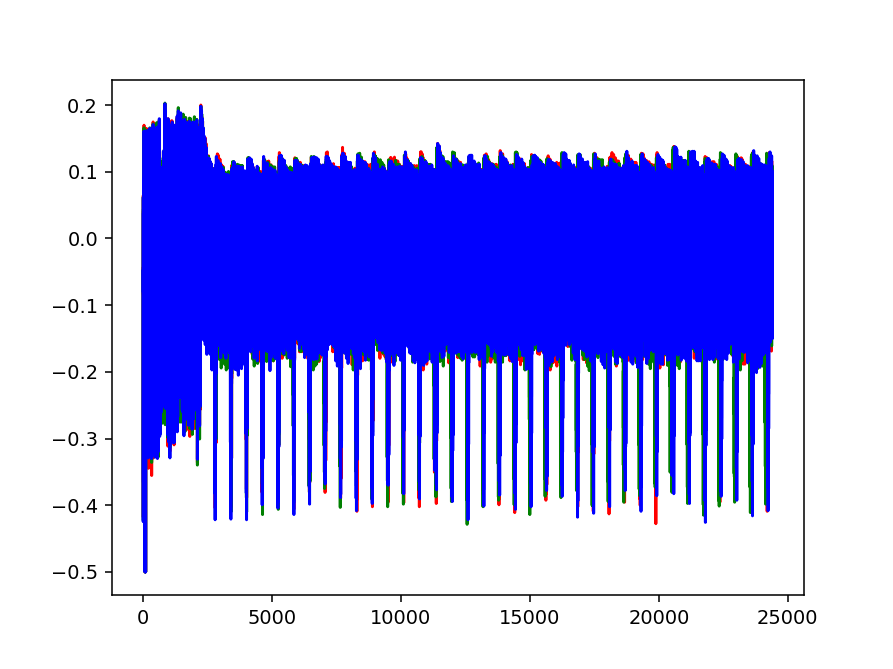

In [9]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace_array[0], 'r')
plt.plot(trace_array[N//2], 'g')
plt.plot(trace_array[N-1], 'b')
plt.show()

## GOST Model and Hamming Weight

In [10]:
sbox = [
    252, 238, 221, 17, 207, 110, 49, 22, 251, 196, 250, 218, 35, 197, 4, 77, 233,
    119, 240, 219, 147, 46, 153, 186, 23, 54, 241, 187, 20, 205, 95, 193, 249, 24, 101,
    90, 226, 92, 239, 33, 129, 28, 60, 66, 139, 1, 142, 79, 5, 132, 2, 174, 227, 106, 143,
    160, 6, 11, 237, 152, 127, 212, 211, 31, 235, 52, 44, 81, 234, 200, 72, 171, 242, 42,
    104, 162, 253, 58, 206, 204, 181, 112, 14, 86, 8, 12, 118, 18, 191, 114, 19, 71, 156,
    183, 93, 135, 21, 161, 150, 41, 16, 123, 154, 199, 243, 145, 120, 111, 157, 158, 178,
    177, 50, 117, 25, 61, 255, 53, 138, 126, 109, 84, 198, 128, 195, 189, 13, 87, 223,
    245, 36, 169, 62, 168, 67, 201, 215, 121, 214, 246, 124, 34, 185, 3, 224, 15, 236,
    222, 122, 148, 176, 188, 220, 232, 40, 80, 78, 51, 10, 74, 167, 151, 96, 115, 30, 0,
    98, 68, 26, 184, 56, 130, 100, 159, 38, 65, 173, 69, 70, 146, 39, 94, 85, 47, 140, 163,
    165, 125, 105, 213, 149, 59, 7, 88, 179, 64, 134, 172, 29, 247, 48, 55, 107, 228, 136,
    217, 231, 137, 225, 27, 131, 73, 76, 63, 248, 254, 141, 83, 170, 144, 202, 216, 133,
    97, 32, 113, 103, 164, 45, 43, 9, 91, 203, 155, 37, 208, 190, 229, 108, 82, 89, 166,
    116, 210, 230, 244, 180, 192, 209, 102, 175, 194, 57, 75, 99, 182
]

kuz_lvec = [0x94, 0x20, 0x85, 0x10, 0xC2, 0xC0, 0x01, 0xFB,
            0x01, 0xC0, 0xC2, 0x10, 0x85, 0x20, 0x94, 0x01]

def kuz_mul_gf256(x, y):
    z = 0
    for i in range(8):
        if (y & 1):
            z ^= x
        if (x & 0x80):
            x = ((x << 1) & 0xFF) ^ 0xC3
        else:
            x = (x << 1) & 0xFF
        y >>= 1
    return z

def L(inputdata):
    res = [block for block in inputdata]
    x = 0
    for j in range(16):
        # An LFSR with 16 elements from GF(2^8)
        x = res[15] # since lvec[15] = 1

        for i in range(14,-1,-1):
            res[i+1] = res[i]
            x ^= kuz_mul_gf256(res[i], kuz_lvec[i])
        res[0] = x
    return res

def SX(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]

## Developing our Correlation Algorithm 

We'll be testing how good our guess is using a measurement called the Pearson correlation coefficient, which measures the linear correlation between two datasets. 

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:

$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$

$\sigma_X$ and $\sigma_Y$ are the standard deviation of the two datasets. This value can be calculated with the following equation:

$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$

As you can see, the calulation is actually broken down pretty nicely into some smaller chunks that we can implement with some simple functions.

In [11]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

## Correlation Attack Implementaiton

<IPython.core.display.Javascript object>


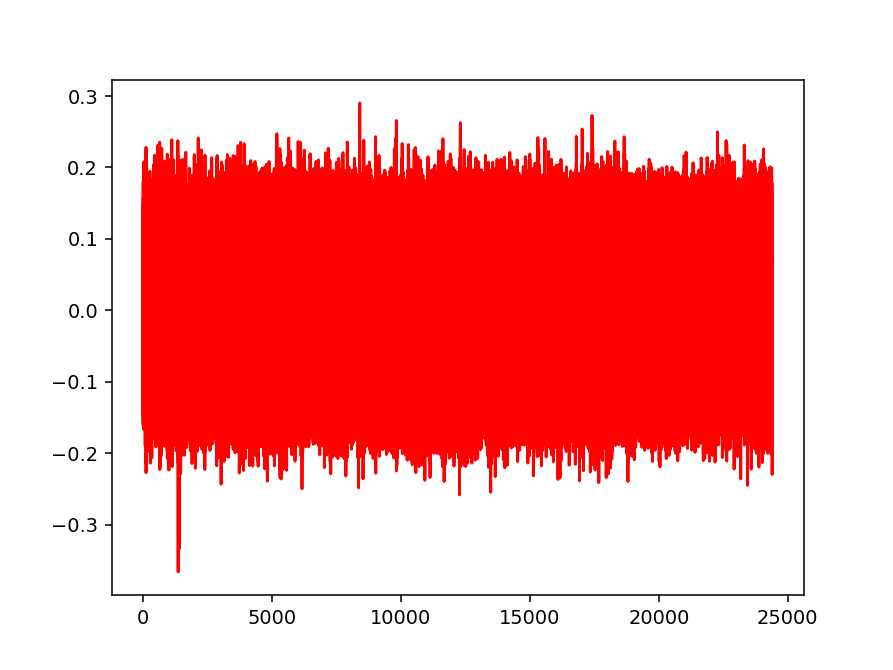

/tmp/ipykernel_8609/1989224445.py:19: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput = correlation/(o_t*o_hws)
/tmp/ipykernel_8609/1989224445.py:37: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput = correlation/(o_t*o_hws)


Best Key Guess: 6c ec c6 7f 28 7d 08 3d eb 87 66 f0 73 8b 36 cf 1f 0a 6a fb 57 ef 08 d4 96 c9 04 6e cc cc 34 0f 
 [0.3661935241427336, 0.4609299947418019, 0.356871712970078, 0.426507632294035, 0.37095087933731535, 0.5026124784071412, 0.44568401588993023, 0.46610470079945154, 0.43142439162244, 0.4451435456348063, 0.3719739459540201, 0.5228924397948245, 0.4367128141198309, 0.4273460997698997, 0.7738469580814635, 0.5460711743373262, 0.28228173630093434, 0.2912619870101719, 0.2717389417738684, 0.27424882305348536, 0.2872112892906246, 0.26348742137822884, 0.26989603778396803, 0.28226869928833764, 0.2786045234865462, 0.2660440182199883, 0.2755814843371492, 0.2641752798194188, 0.2710055000920712, 0.2951862365930734, 0.2604119404129349, 0.2660406620050882]


In [12]:
t_bar = np.sum(trace_array, axis=0)/len(trace_array)
o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

cparefs = [0] * 32 #put your key byte guess correlations here
bestguess = [0] * 32 #put your key byte guesses here

lsx_array = [[]] * N # intermediate calculations with correct K1

plt.figure()

#K1
for bnum in range(16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        hws = np.array([[HW[SX(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        if (bnum == 0): # plot Pearson coefficients for the first byte of the key
            plt.plot(cpaoutput, 'r')
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)

for j in range(N):
    lsx_array[j] = L([SX(textin_array[j][bnum],bestguess[bnum]) for bnum in range(16)])

#K2
for bnum in range(16):
    maxcpa = [0] * 256
    for kguess in range(256):
        hws = np.array([[HW[SX(lsx[bnum],kguess)] for lsx in lsx_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum+16] = np.argmax(maxcpa)
    cparefs[bnum+16] = max(maxcpa)

plt.show()

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print("\n", cparefs)

With one final check to make sure you've got the correct key:

In [13]:
key = [0x6c,0xec,0xc6,0x7f,0x28,0x7d,0x08,0x3d,
       0xeb,0x87,0x66,0xf0,0x73,0x8b,0x36,0xcf,
       0x16,0x4e,0xd9,0xb2,0x46,0x95,0x10,0x90,
       0x86,0x9d,0x08,0x28,0x5d,0x2e,0x19,0x3b]

for bnum in range(32):
    assert bestguess[bnum] == key[bnum], \
    "Byte {} failed, expected {:02X} got {:02X}".format(bnum, key[bnum], bestguess[bnum])
print("✔️ OK to continue!")

AssertionError: Byte 16 failed, expected 16 got 1F